In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from skimage.metrics import structural_similarity as ssim
from PIL import Image


In [ ]:
def preprocess(inputdir, target_size=(128, 128)):
    images = []
    for root, _, files in os.walk(inputdir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path).convert('L')
                    img = img.resize(target_size)
                    img = np.array(img) / 255.0
                    images.append(img)
                except Exception as e:
                    print(f"Error loading {img_path} : {e}")
    return np.array(images)


In [ ]:
if not os.path.exists("./MURA"):
    !wget -O MURA-v1.1.zip https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
    !unzip MURA-v1.1.zip -d ./MURA


In [ ]:
train_path = '/content/MURA/MURA-v1.1/train'
valid_path = '/content/MURA/MURA-v1.1/valid'
def load_data_in_batches(inputdir, batch_size=500):
    images = preprocess(inputdir)
    return images[:batch_size]  # Load only a limited number of images

train = load_data_in_batches(train_path, batch_size=2000)
valid = load_data_in_batches(valid_path, batch_size=500)


Error loading /content/MURA/MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image1.png : cannot identify image file '/content/MURA/MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image1.png'
Error loading /content/MURA/MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image3.png : cannot identify image file '/content/MURA/MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image3.png'
Error loading /content/MURA/MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image2.png : cannot identify image file '/content/MURA/MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image2.png'
Error loading /content/MURA/MURA-v1.1/train/XR_WRIST/patient07840/study1_negative/._image1.png : cannot identify image file '/content/MURA/MURA-v1.1/train/XR_WRIST/patient07840/study1_negative/._image1.png'


In [ ]:
train = train.reshape(-1, 128, 128, 1).astype('float32')
valid = valid.reshape(-1, 128, 128, 1).astype('float32')


In [ ]:
noise_factor = 0.1  # Reduced noise factor for easier denoising
train_noisy = train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train.shape)
valid_noisy = valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid.shape)

train_noisy = np.clip(train_noisy, 0.0, 1.0)
valid_noisy = np.clip(valid_noisy, 0.0, 1.0)


In [ ]:
input_img = Input(shape=(128, 128, 1))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.4)(x)

# Bottleneck
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

output_img = x


In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [ ]:
from tensorflow.keras.applications import VGG19
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg.trainable = False

layer_names = ['block2_conv2', 'block3_conv3', 'block5_conv4']
feature_models = {layer_name: Model(inputs=vgg.input, outputs=vgg.get_layer(layer_name).output) for layer_name in layer_names}
def multi_layer_perceptual_loss(y_true, y_pred):
    y_true_rgb = tf.image.grayscale_to_rgb(y_true)
    y_pred_rgb = tf.image.grayscale_to_rgb(y_pred)

    perceptual_losses = []
    for layer_name, feature_model in feature_models.items():
        true_features = feature_model(y_true_rgb)
        pred_features = feature_model(y_pred_rgb)
        perceptual_loss = tf.reduce_mean(tf.square(true_features - pred_features))
        perceptual_losses.append(perceptual_loss)

    perceptual_loss_total = 0.5 * perceptual_losses[0] + 0.3 * perceptual_losses[1] + 0.2 * perceptual_losses[2]
    pixel_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return perceptual_loss_total + 0.5 * pixel_loss

model.compile(optimizer=Adam(learning_rate=0.0002), loss=multi_layer_perceptual_loss)


In [ ]:
model.fit(train_noisy, train, validation_data=(valid_noisy, valid), epochs=130, batch_size=16, callbacks=[lr_scheduler])


Epoch 1/130
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 206ms/step - loss: 6.3874 - val_loss: 3.7699 - learning_rate: 2.0000e-04
Epoch 2/130
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step - loss: 1.9359 - val_loss: 5.3735 - learning_rate: 2.0000e-04
Epoch 3/130
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - loss: 1.5375 - val_loss: 6.1977 - learning_rate: 2.0000e-04
Epoch 4/130
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 206ms/step - loss: 1.4307 - val_loss: 8.3989 - learning_rate: 2.0000e-04
Epoch 5/130
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 1.2528 - val_loss: 1.7356 - learning_rate: 1.0000e-04
Epoch 6/130
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - loss: 1.2062 - val_loss: 1.1622 - learning_rate: 1.0000e-04
Epoch 7/130
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - loss: 1.1360 - val_loss: 0.9974 - learning_rate: 1.0000e-04
Epoch 8/130
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 189ms/step - loss: 1.0844 - val_loss: 0.9515 - learning_rate: 1.0000e-04
Epoch 9/130
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step 

In [ ]:
model.save('image_denoisingy.keras')


In [ ]:
pred = model.predict(valid_noisy)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


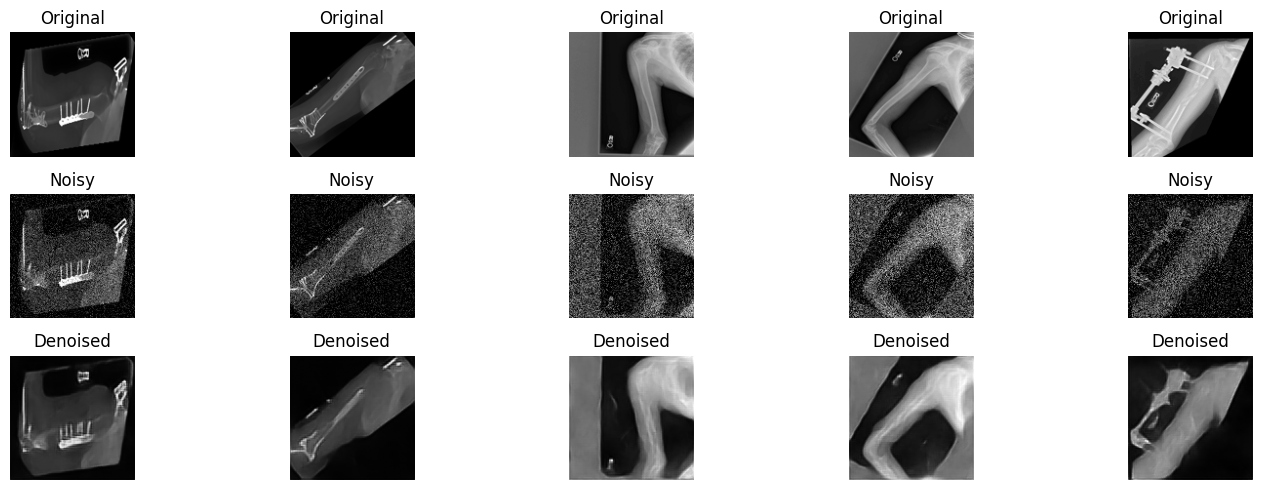

In [ ]:
plt.figure(figsize=(15, 5))
for i in range(5):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(valid[i].reshape(128, 128), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(3, 5, i + 6)
    plt.imshow(valid_noisy[i].reshape(128, 128), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    ax = plt.subplot(3, 5, i + 11)
    plt.imshow(pred[i].reshape(128, 128), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def sharpen_image(image):
    sharpen_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    return cv2.filter2D(image, -1, sharpen_kernel)

sharpened_pred = np.array([sharpen_image(img.reshape(128, 128)) for img in pred])


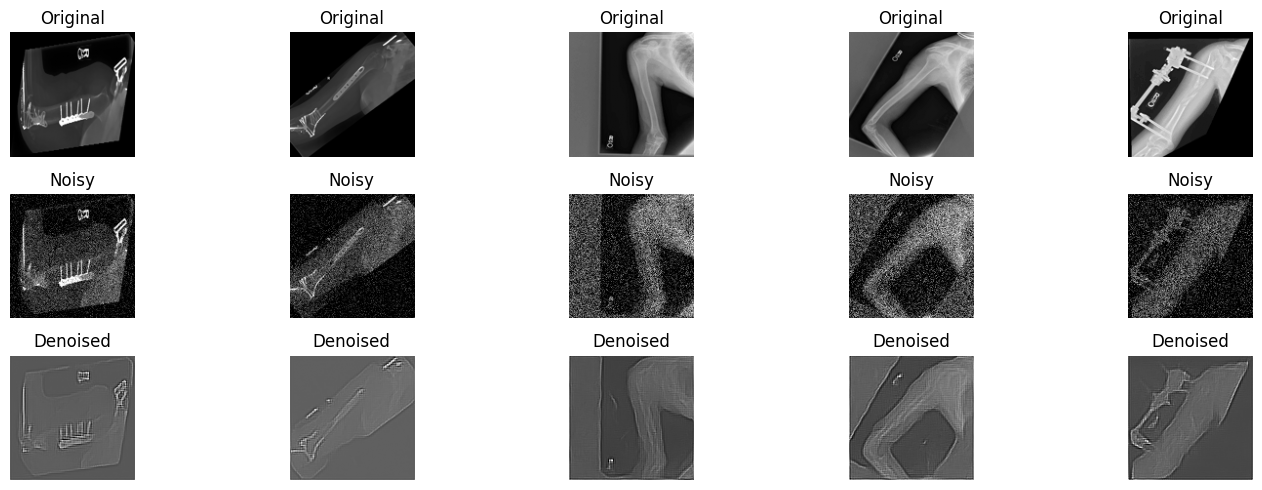

In [ ]:
plt.figure(figsize=(15, 5))
for i in range(5):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(valid[i].reshape(128, 128), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(3, 5, i + 6)
    plt.imshow(valid_noisy[i].reshape(128, 128), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    ax = plt.subplot(3, 5, i + 11)
    plt.imshow(sharpened_pred[i], cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

plt.tight_layout()
plt.show()
